In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import metrics 
from sklearn.preprocessing import StandardScaler #Z-score variables

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from sklearn.model_selection import GridSearchCV

%precision %.7g
%matplotlib inline

# KNN

## 1. Explore

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Build and Evaluate Model

In [3]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

z = StandardScaler()

X_train[predictors] = z.fit_transform(X_train[predictors])
X_test[predictors] = z.transform(X_test[predictors])

knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)








KNeighborsClassifier()

------------
Index(['x0', 'x1'], dtype='object')


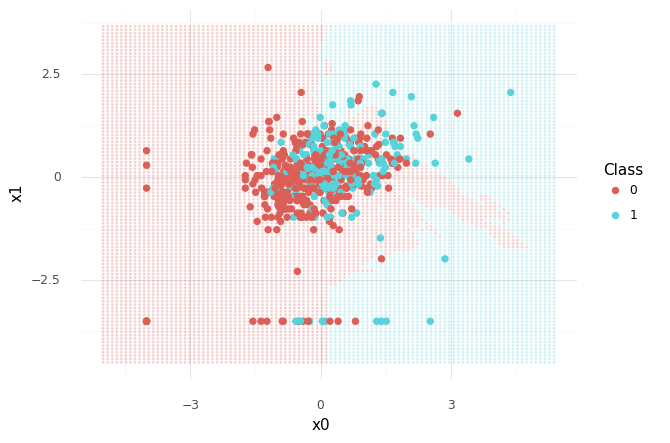

<ggplot: (8763217425097)>


In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plotKNN2D(Xdf,y,k):
    # X can only have 2 dimensions becuase of plotting
    print("------------")
    print(Xdf.columns)
    
    
    Xdf.columns = ["x0", "x1"]

    #grab the range of features for each feature
    x0_range = np.linspace(min(Xdf["x0"]) - np.std(Xdf["x0"]),
                           max(Xdf["x0"]) + np.std(Xdf["x0"]), num = 100)
    x1_range = np.linspace(min(Xdf["x1"]) - np.std(Xdf["x1"]),
                           max(Xdf["x1"]) + np.std(Xdf["x1"]), num = 100)

    #get all possible points on graph
    x0 = np.repeat(x0_range,100)
    x1 = np.tile(x1_range,100)
    x_grid = pd.DataFrame({"x0": x0, "x1": x1})

    #build model
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(Xdf,y)

    # bredict all background points
    p = knn.predict(x_grid)
    x_grid["p"] = p #add to dataframe
    
    #build the plot
    bound = (ggplot(x_grid, aes(x = "x0", y = "x1", color = "factor(p)")) +
                 geom_point(alpha = 0.2, size = 0.2) + theme_minimal() +
                 scale_color_discrete(name = "Class") +
                 geom_point(data = Xdf, mapping = aes(x = "x0", y = "x1", color = "factor(y)"), size = 2))
    print(bound)
    
    
plotKNN2D(X_train,y_train, k = 15)

In [7]:
# acc
print("Train Acc: ", accuracy_score(y_train, knn.predict(X_train)))
print("Test Acc: ", accuracy_score(y_test, knn.predict(X_test)))

Train Acc:  0.757328990228013
Test Acc:  0.6493506493506493


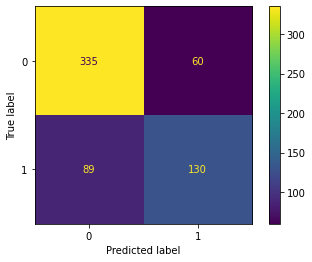

In [8]:
# confusion
plot_confusion_matrix(knn, X_train, y_train)

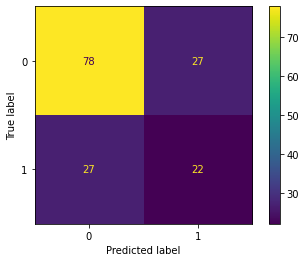

In [9]:
plot_confusion_matrix(knn, X_test, y_test)

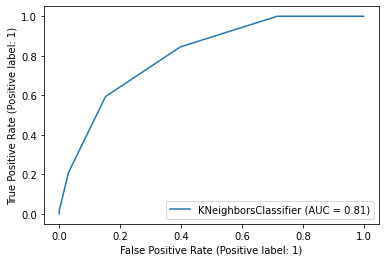

In [10]:
# roc auc
plot_roc_curve(knn, X_train, y_train)

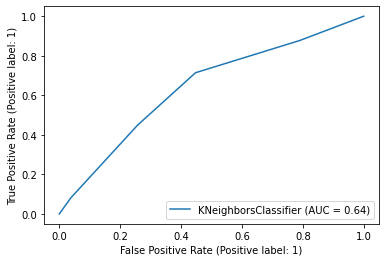

In [11]:
plot_roc_curve(knn, X_test, y_test)

# Parameter Tuning

## Option 1: By Hand

In [13]:
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# split training set into train and validation
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size = 0.2)

# choose possible parameter values to test
poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

# test parameters
for k in poss_k:
  knn = KNeighborsClassifier(n_neighbors = k)
  knn.fit(X_train2, y_train2)

  acc[k] = accuracy_score(y_val, knn.predict(X_val))

print(acc)

# choose best param
chosen_k = max(acc, key = acc.get)
print(chosen_k)

# fit model with best param
knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train, y_train)

print("Test Acc: ", accuracy_score(y_test, knn_final.predict(X_test)))



{1: 0.5853658536585366, 2: 0.6585365853658537, 3: 0.6178861788617886, 4: 0.6504065040650406, 5: 0.6178861788617886, 6: 0.6747967479674797, 7: 0.6504065040650406, 8: 0.6504065040650406, 9: 0.6341463414634146, 10: 0.6747967479674797}
6
Test Acc:  0.5909090909090909


## Option 2 (recommended): Grid Search

In [14]:
# what K do I use??

predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn2 = KNeighborsClassifier()

# choose potential values of k
ks = {"n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(knn2, ks, scoring = "accuracy", cv = 5, refit = True)

grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30)}, scoring='accuracy')

In [15]:
grid.best_estimator_.get_params()["n_neighbors"]

29

In [ ]:
# more things you can pull: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [16]:
print("Train Acc: ", accuracy_score(y_train, grid.predict(X_train)))
print("Test Acc : ", accuracy_score(y_test, grid.predict(X_test)))

Train Acc:  0.6807817589576547
Test Acc :  0.5714285714285714


## Data Leakage (Reprise)

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# what K do I use??
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# create model
knn = KNeighborsClassifier()

# create z score object
z = make_column_transformer((StandardScaler(),["BMI", "BloodPressure"]),
                            remainder = "passthrough")

# make pipeline
pipe = make_pipeline(z, knn)
# print(pipe.get_params().keys())

# choose potential values of k
ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, ks, scoring = "accuracy", cv = 5, refit = True)

grid.fit(X_train, y_train)

print(grid.best_estimator_.get_params()["kneighborsclassifier__n_neighbors"])
print("Train: ", accuracy_score(y_train, grid.predict(X_train)))
print("Test : ", accuracy_score(y_test, grid.predict(X_test)))






22
Train:  0.6889250814332247
Test :  0.6428571428571429


## What else can we Grid Search???

Grid search is a super simple way to choose hyperparameters. There other more efficient ways to tune hyperparameters, but this does a good job in simple cases like the ones we will see in class.

It doesn't just work for K in KNN though! Think about `max_depth` when building a DecisionTree, this can be chosen using `GridSearchCV()` as well.

In [28]:
from sklearn.tree import DecisionTreeClassifier # Decision Tree

# load data from DT lecture
gpa = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/CCfraud.csv")

# set X and y
X = gpa[["home","amount","cashBack"]]
y = gpa["fraud"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# make z score object
z = make_column_transformer((StandardScaler(), ["amount"]),
                            remainder = "passthrough")

# make model
dt = DecisionTreeClassifier()

# make pipe
pipe = make_pipeline(z,dt)
# print(pipe.get_params().keys())

# choose potential values of max depths
depths = {"decisiontreeclassifier__max_depth": range(1,9)}

# use grid search to find best parameters
grid = GridSearchCV(pipe, depths, scoring = "accuracy", cv = 5, refit = True)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['amount'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': range(1, 9)},
             scoring='accuracy')

In [29]:
grid.best_estimator_.get_params()["decisiontreeclassifier__max_depth"]

3

## With KFold

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# what K do I use??
predictors = ["BMI", "BloodPressure"]

X = data[predictors]
y = data["Outcome"]

# split into training and test
kf = KFold()

for train,test in kf.split(X):
    X_train = X.iloc[train,]
    X_test = X.iloc[test,]
    y_train = y[train]
    y_test = y[test]
    
    # create model
    knn = KNeighborsClassifier()

    # create z score object
    z = make_column_transformer((StandardScaler(), ["BMI", "BloodPressure"]),
                                remainder = "passthrough")
    # make pipeline
    pipe = make_pipeline(z,knn)

    # choose potential values of k
    ks = {"kneighborsclassifier__n_neighbors": range(1,30)}

    # use grid search to find best parameters
    grid = GridSearchCV(pipe, ks, scoring = "accuracy", cv = 5, refit = True)
    grid.fit(X_train, y_train)

    

